In [1]:
from binance.um_futures import UMFutures
import okx.MarketData as MarketData
from tqdm import tqdm
import pandas as pd
import numpy as np
from datetime import datetime
import time
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
class strategy_backtester:
    def __init__(self, start, end=datetime.strftime(datetime.now(), "%Y-%m-%d %H:%M:%S")):
        self.start = int(datetime.strptime(start, "%Y-%m-%d %H:%M:%S").timestamp())*1000
        self.end = int(datetime.strptime(end, "%Y-%m-%d %H:%M:%S").timestamp())*1000
        self.full_timeindex = pd.date_range(start=start, end=end, freq="H") # for checking missing candlesticks
        self.binance_data= self.get_binance_data() # fetch OHLCV from Binance
        self.okx_data = self.get_okx_data() # fetch OHLCV from OKX

    def get_binance_data(self):
        col_names_binance = ["Open_Time", "Open", "High", "Low", "Close", "Volume", "Close_Time", "Quote_Asset_Volume", "Number_Of_Trades", 
                     "Taker_Buy_Base_Asset_Volume", "Taker_Buy_Quote_Asset_Volume", "Ignore"]
        binance_data = pd.DataFrame(columns=col_names_binance)
        col_names_binance = {i:_ for i,_ in enumerate(col_names_binance)}
        um_futures_client = UMFutures()
        end_loop = 0

        if self.end - self.start >= 3600000*1000: # check if the period we want exceeds the binance api limit
            futures_data = um_futures_client.klines("BTCUSDT", "1h", startTime = self.start, limit=1000)
        else:
            futures_data = um_futures_client.klines("BTCUSDT", "1h", startTime = self.start, endTime=self.end, limit=1000)
            end_loop = 1 # stop the loop

        time.sleep(0.01) # avoid exceeding request limit

        futures_data = pd.DataFrame(futures_data)
        futures_data = futures_data.rename(columns=col_names_binance)
        binance_data = pd.concat([binance_data, futures_data])
        
        while end_loop==0:
            startTime = list(binance_data["Close_Time"])[-1] + 1
            if self.end - startTime >= 3600000*1000:
                futures_data = um_futures_client.klines("BTCUSDT", "1h", startTime = startTime, limit=1000)
            else:
                futures_data = um_futures_client.klines("BTCUSDT", "1h", startTime = startTime, endTime=self.end, limit=1000)
                end_loop = 1

            futures_data = pd.DataFrame(futures_data)
            futures_data = futures_data.rename(columns=col_names_binance)
            binance_data = pd.concat([binance_data, futures_data])

            time.sleep(0.01)

        binance_data = binance_data.astype(np.float64)
        binance_data["Open_Time"] = pd.to_datetime(binance_data["Open_Time"], unit="ms") + pd.Timedelta(hours=8) # change back to HK tz
        binance_data["Close_Time"] = pd.to_datetime(binance_data["Close_Time"], unit="ms") + pd.Timedelta(hours=8)
        binance_data = binance_data.set_index("Open_Time")
        binance_data = binance_data.sort_index()
        binance_data = binance_data.iloc[:,:5] # get the OHLCV data only

        if len(binance_data.index) != len(self.full_timeindex): # check if missing candlestick
            time_diff = self.full_timeindex.difference(binance_data.index)
            for timestamp in time_diff:
                binance_data.loc[timestamp] = np.nan
            binance_data = binance_data.sort_index()
        
        # fill the missing data if any
        binance_data = binance_data.ffill()
        binance_data = binance_data.bfill()

        return binance_data
    
    def get_okx_data(self):
        col_names_okx = ["Open_Time", "Open", "High", "Low", "Close", "Volume", "volCcy", "volCcyQuote", "confirm"]
        okx_data = pd.DataFrame(columns=col_names_okx)
        col_names_okx = {i:_ for i,_ in enumerate(col_names_okx)}
        end_loop = 0
        flag = "1"  # Production trading:0 , demo trading:1
        marketDataAPI =  MarketData.MarketAPI(flag=flag)

        if self.end - self.start >= 3600000*300: # check if the period we want exceeds the okx api limit
            end = self.start + 3600000*300 - 1
            futures_data = marketDataAPI.get_history_candlesticks(instId="BTC-USDT", bar="1H", before=self.start-1, after=end, limit=300)["data"]
        else:
            futures_data = marketDataAPI.get_history_candlesticks(instId="BTC-USDT", bar="1H", before=self.start-1, after=self.end, limit=300)["data"]
            end_loop = 1 # stop the loop

        time.sleep(0.11) # avoid exceeding request limit

        futures_data = pd.DataFrame(futures_data)
        futures_data = futures_data.rename(columns=col_names_okx)
        okx_data = pd.concat([okx_data, futures_data])
        okx_data = okx_data.sort_values(by="Open_Time")
        
        while end_loop==0:
            startTime = int(list(okx_data["Open_Time"])[-1]) + 3600000
            if self.end - startTime >= 3600000*300:
                end = startTime + 3600000*300
                futures_data = marketDataAPI.get_history_candlesticks(instId="BTC-USDT", bar="1H", before=startTime-1, after=end, limit=300)["data"]
            else:
                futures_data = marketDataAPI.get_history_candlesticks(instId="BTC-USDT", bar="1H", before=startTime-1, after=self.end, limit=300)["data"]
                end_loop = 1

            futures_data = pd.DataFrame(futures_data)
            futures_data = futures_data.rename(columns=col_names_okx)
            okx_data = pd.concat([okx_data, futures_data])
            okx_data = okx_data.sort_values(by="Open_Time")

            time.sleep(0.11)

        okx_data = okx_data.astype(np.float64)
        okx_data["Open_Time"] = pd.to_datetime(okx_data["Open_Time"], unit="ms") + pd.Timedelta(hours=8) # change back to HK tz
        okx_data = okx_data.set_index("Open_Time")
        okx_data = okx_data.sort_index()
        okx_data = okx_data.iloc[:,:5] # get the OHLCV data only

        if len(okx_data.index) != len(self.full_timeindex): # check if missing candlestick
            time_diff = self.full_timeindex.difference(okx_data.index)
            for timestamp in time_diff:
                okx_data.loc[timestamp] = np.nan
            okx_data = okx_data.sort_index()
        
        # fill the missing data if any
        okx_data = okx_data.ffill()
        okx_data = okx_data.bfill()

        return okx_data
    
    def backtest(self, x, y, initial_fund=100000, trading_fee=0.1/100):
        # use close price for signal generation so it matches with execution using next hour's open
        sma = self.binance_data["Close"].rolling(x).mean() 
        sd = self.binance_data["Close"].rolling(x).std()
        z_score = (self.binance_data["Close"]-sma)/sd
        self.equity = pd.Series(index=self.binance_data.index) # opening equity for the hour
        self.equity.iloc[0] = initial_fund
        position = 0 # for checking current position
        return_open = self.binance_data["Open"].diff()
        for i in range(len(self.equity.index[:-1])):
            if z_score.iloc[i] == np.nan:
                self.equity.iloc[i+1] = self.equity.iloc[i] # same fund equity because no data
            else:
                if position == 0:
                    if z_score.iloc[i] > y:
                        position = 1
                        # minus the trading fee when entering a position
                        self.equity.iloc[i+1] = self.equity.iloc[i] - self.binance_data["Open"].iloc[i+1]*trading_fee
                    elif z_score.iloc[i] < -y:
                        position = -1
                        # minus the trading fee when entering a position
                        self.equity.iloc[i+1] = self.equity.iloc[i] - self.binance_data["Open"].iloc[i+1]*trading_fee
                    else:
                        self.equity.iloc[i+1] = self.equity.iloc[i] # same fund equity because not invested
                elif position == 1:
                    self.equity.iloc[i+1] = self.equity.iloc[i] + return_open.iloc[i+1] # add the PnL
                    if z_score.iloc[i] < 0: # close position
                        position = 0
                        # minus the trading fee when closing a position
                        self.equity.iloc[i+1] = self.equity.iloc[i+1] - self.binance_data["Open"].iloc[i+1]*trading_fee
                else:
                    self.equity.iloc[i+1] = self.equity.iloc[i] - return_open.iloc[i+1] # add the PnL
                    if z_score.iloc[i] > 0: # close position
                        position = 0
                        # minus the trading fee when closing a position
                        self.equity.iloc[i+1] = self.equity.iloc[i+1] - self.binance_data["Open"].iloc[i+1]*trading_fee

    def get_performance_metrics(self, x, rf=0.02):
        # only use the equity after we have enough candles for computing signals
        equity = self.equity[x:] 
        PnL = np.log(equity).diff().dropna()
        summary = {}
        summary["Total Return"] = equity[-1]/equity[0] - 1
        summary["annualized_return"] = 24*365*np.mean(PnL)
        summary["annualized_sd"] = np.sqrt(24*365)*np.std(PnL)
        summary["Sharpe Ratio"] = (summary["annualized_return"]-rf)/summary["annualized_sd"] # use log return for Sharpe
        summary["CAGR"] = (equity[-1]/equity[0])**(1/((PnL.index[-1]-PnL.index[0]).days/365))-1
        roll_max = equity.cummax()
        summary["Maximum Drawdown"] = abs((equity/roll_max-1).min())
        summary["Calmar Ratio"] = summary["CAGR"]/summary["Maximum Drawdown"] # use geometric return for Calmar
        return summary
                        
    def grid_search_parameter(self, x_range, y_range, initial_fund=100000, trading_fee=0.1/100):
        self.summary = pd.DataFrame(index=x_range, columns=y_range)
        for x in x_range:
            for y in tqdm(y_range, desc=f"x = {round(x, 2)}"):
                self.backtest(x, y, initial_fund, trading_fee)
                total_sharpe = self.get_performance_metrics(x)["Sharpe Ratio"]
                self.summary.loc[x,y] = total_sharpe

    def find_max_sharpe_and_plot(self):
        data = np.matrix(self.summary)
        amax = data.argmax() # find the optimal x and y
        row, col = (amax//data.shape[1], amax%data.shape[1])
        print(f"\nThe max sharpe of is {self.summary.iloc[row, col]:.4f}")
        print(f"The optimal (x,y) is ({self.summary.index[row]:.2f}, {self.summary.columns[col]:.2f})")
        plt.figure(figsize = (15,7))
        sns.heatmap(self.summary.astype(float), annot=True)
        plt.title("Sharpe Ratio Heatmap")
        plt.xlabel("y")
        plt.ylabel("x")
        plt.show()
        self.backtest(self.summary.index[row], self.summary.columns[col]) # get the equity curve of the best params
        self.equity.plot(figsize = (15,7), title="Equity curve of best Sharpe", ylabel="equity", xlabel="time")
        plt.show()
        print(self.get_performance_metrics(self.summary.index[row]))
        



In [3]:
backtester = strategy_backtester("2021-01-01 00:00:00", "2023-12-31 23:59:59")

In [4]:
x_range = np.arange(100, 2401, 100)
y_range = np.arange(0.25, 3.1, 0.25)

In [5]:
backtester.grid_search_parameter(x_range, y_range)

x = 2400: 100%|██████████| 12/12 [00:08<00:00,  1.37it/s]



The max sharpe of is 0.8789
The optimal (x,y) is (1400.00, 2.25)


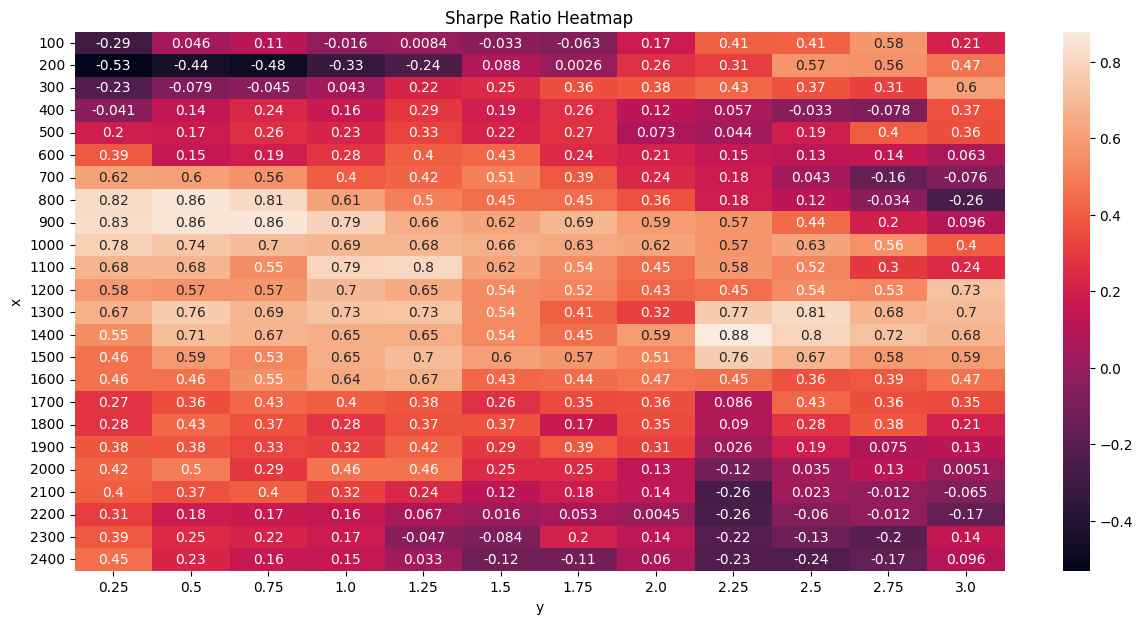

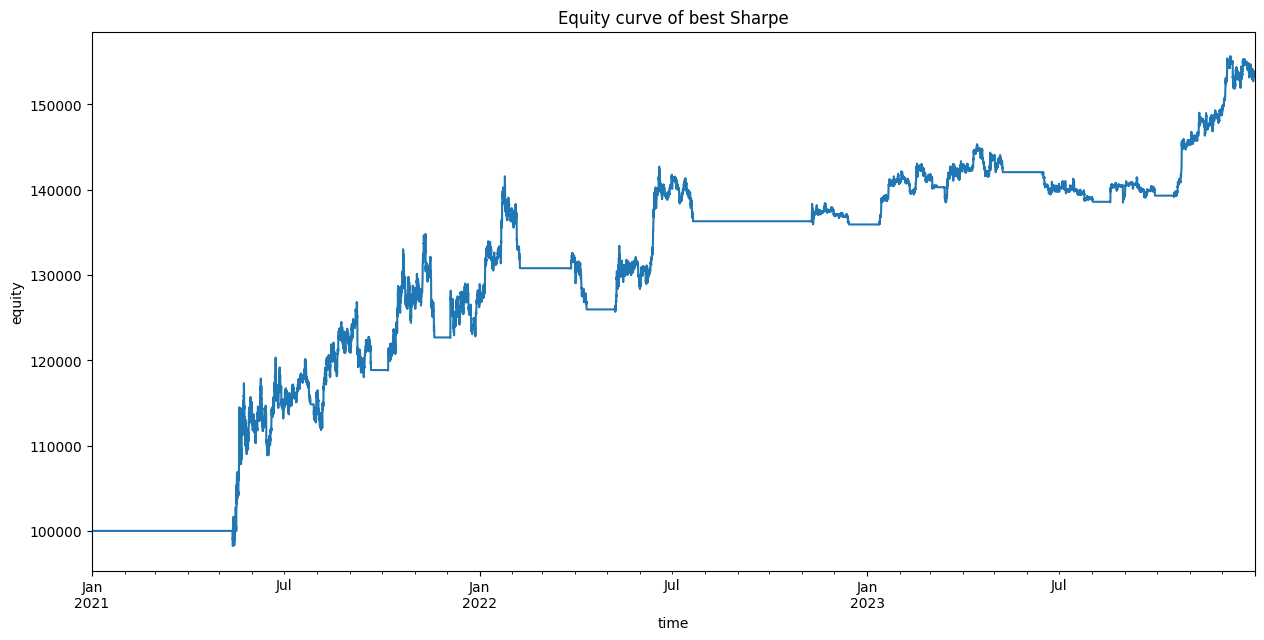

{'Total Return': 0.5365026898000116, 'annualized_return': 0.15123186438099306, 'annualized_sd': 0.14930609313708842, 'Sharpe Ratio': 0.8789451362879067, 'CAGR': 0.16337248280436678, 'Maximum Drawdown': 0.1119424491303973, 'Calmar Ratio': 1.4594328074246499}


In [6]:
backtester.find_max_sharpe_and_plot()